In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Fetch ticker of S&P500 constituents
SP_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_table = pd.read_html(SP_url)[0]
ticker_symbols = SP_table["Symbol"]

ticker_symbols = ticker_symbols.to_list()

#Fetch Historical data on Yahoo Finance
P = yf.download(ticker_symbols,start=datetime(2019,1,1),end=datetime(2024,3,29))["Adj Close"]

#Align number of columns dropping the stock with inconsistent number of observation
null  = P.describe().T.reset_index()
null = null["Ticker"][null["count"] < 1319]
null = null.to_list()
P = P.drop(labels=null,axis=1)


#Upload the FFC Risk Factor Data downloaded by FAMA-FRENCH website
Factors = pd.read_excel("C:\\Users\\cdecinti\\desktop\\North_America_5_Factors_Daily.xlsx").set_index("Data")

#Manipulate DB and Return calculation
db = pd.merge(P,Factors,how="left",left_index=True,right_index=True)
RF = db["RF_y"]
P = db.drop(labels=["Mkt-RF","HML","SMB","RMW","CMA","RF_y","WML"],axis=1)
Factors = db[["Mkt-RF","HML","SMB","WML","CMA","RMW"]]
R = P.pct_change().dropna()
ExRet = R.subtract(RF[1:],axis=0)

#Fetch the benchmark data
SP = yf.download("^GSPC",start=datetime(2019,1,1),end=datetime(2024,3,29))["Adj Close"]
SPR = SP.pct_change().dropna()

#Features calculation
sigma_m = SPR.std()*np.sqrt(252)                            #Std Dev S&P Returns annualized
sigma_i = pd.DataFrame(R.std()*np.sqrt(252))                #Std Dev any stock annualized
sigma_i.columns = ["sigma_i"]
Rbar = pd.DataFrame(((1+R.mean())**252)-1)                  #Expected Return any stock annualized
Rbar.columns = ["R_mean"]                                   
RFm = (RF.mean())   

[*********************100%%**********************]  503 of 503 completed

5 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SOLV', 'SW', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1711684800")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-01 00:00:00 -> 2024-03-29 00:00:00)')
[*********************100%%**********************]  1 of 1 completed


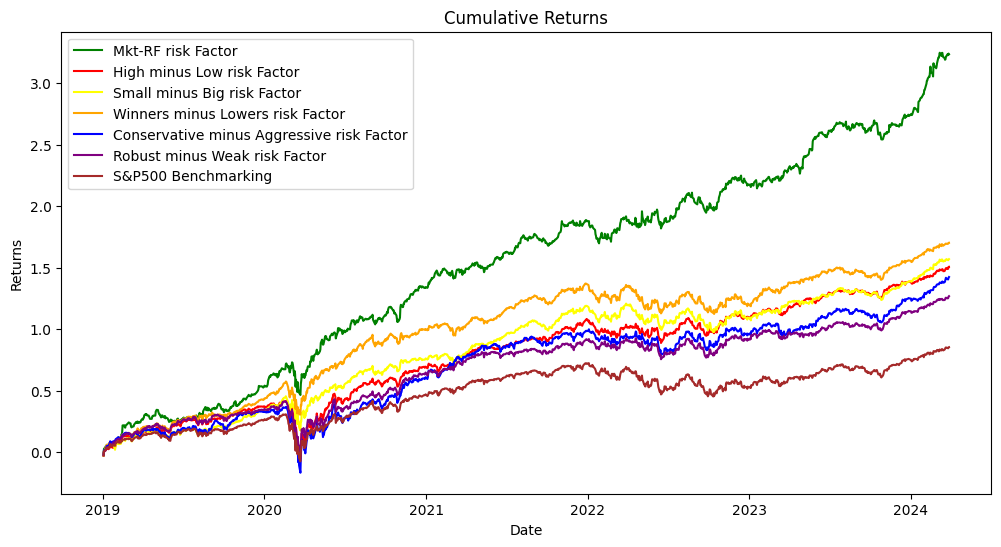

In [3]:
#Single index model estimated for any FFC factor with any stock in S&P pool

summary = {factor: [] for factor in Factors.columns}        #dict to store weigths 
lista = {factor: [] for factor in Factors.columns}          #dict to store optimal stock list

for Factor in Factors.columns:
    betas = []
    X = Factors[1:][Factor]
    X = sm.add_constant(X)
    name = X.columns.to_list()

    for stock in ExRet.columns:
        model = sm.OLS(ExRet[stock]*100,X)
        fit = model.fit(mcov_type='HAC')
        # print(f'{fit.summary(yname=stock,xname=name)}')
        betas.append(fit.params)

    ticker = pd.DataFrame(ExRet.columns)
    ticker.columns = ["Ticker"]
    betas = pd.merge(ticker,pd.DataFrame(betas),how="left",left_index=True,right_index=True)
    betas = betas.set_index("Ticker")

    #Process for select optimal stock with the C* law for single/multi index model

    tab = pd.merge(betas,Rbar,how="left",left_index=True,right_index=True)
    tab = pd.merge(tab,sigma_i,how="left",left_index=True,right_index=True)

    #Excess Return and Beta ratio
    tab["num"] = tab["R_mean"].subtract(RFm)
    tab["ExRet_beta"] = tab["num"] / tab[name[1]]
    tab = tab.sort_values("ExRet_beta",ascending=False)

    #Calculation of the single components for the final C* calculus
    tab2 = tab.copy()
    tab2["step1"] = (tab2["ExRet_beta"]*tab2[name[1]] ) / tab2["sigma_i"]**2
    tab2["step2"] = tab2[name[1]]**2 / tab2["sigma_i"]**2
    tab2["num2"] = tab2["step1"].cumsum()
    tab2["den"] = tab2["step2"].cumsum()

    #Ci Calculus and boolean compare for selecting criteria
    tab2["Ci"] = (sigma_m**2 * tab2["num2"]) / (1 + sigma_m**2 * tab2["den"])
    tab2["Optimal"] = tab2["ExRet_beta"] > tab2["Ci"]

    #Export in Excel
    # tab2.to_excel(f"C:\\Users\\cdecinti\\desktop\\report_{Factor}.xlsx")

    #Pesi ottimali
    weights = tab2[tab2["Optimal"]==True]
    Ci = weights["Ci"].iloc[-1]
    weights["Z"] = (weights[name[1]]/weights["sigma_i"]**2)*(weights["ExRet_beta"] - Ci)
    weights["weights"] = weights["Z"] / weights["Z"].sum()

    appo = weights["weights"].reset_index()
    summary[Factor] = appo["weights"]

    lista[Factor] = weights.index.to_list()

summary = list(summary.values())
lista = list(lista.values())

#Select stock and weigths
#Mrkt Premium
MKT_list = lista[0]
MKT_weights =  summary[0]

#HML
HML_list = lista[1]
HML_weights = summary[1]

#SMB
SMB_list = lista[2]
SMB_weights = summary[2]

#WML
WML_list = lista[3]
WML_weights = summary[3]

#CMA
CMA_list = lista[4]
CMA_weights = summary[4]

#RMW
RMW_list = lista[5]
RMW_weights = summary[5]

#Subsetting Returns based on list of selected stock
sel_Mkt = R[MKT_list]
sel_HML = R[HML_list]
sel_SMB = R[SMB_list]
sel_WML = R[WML_list]
sel_CMA = R[CMA_list]
sel_RMW = R[RMW_list]

#Calculate Return for each portfolio
Port_Mkt = pd.DataFrame(np.dot(sel_Mkt,MKT_weights))
Port_HML = pd.DataFrame(np.dot(sel_HML,HML_weights))
Port_SMB = pd.DataFrame(np.dot(sel_SMB,SMB_weights))
Port_WML = pd.DataFrame(np.dot(sel_WML,WML_weights))
Port_CMA = pd.DataFrame(np.dot(sel_CMA,CMA_weights))
Port_RMW = pd.DataFrame(np.dot(sel_RMW,RMW_weights))

#Plot cumulative Returns
SPR = pd.DataFrame(SPR)
Port = pd.concat([Port_Mkt,Port_HML,Port_SMB,Port_WML,Port_CMA,Port_RMW],axis=1).set_index(SPR.index)
Port.columns = ["Port_Mkt","Port_HML","Port_SMB","Port_WML","Port_CMA","Port_RMW"]

plt.rcParams["figure.figsize"] = (12,6)
plt.plot(Port["Port_Mkt"].cumsum(),color="green",label="Mkt-RF risk Factor")
plt.plot(Port["Port_HML"].cumsum(),color="red",label="High minus Low risk Factor")
plt.plot(Port["Port_SMB"].cumsum(),color="yellow",label="Small minus Big risk Factor")
plt.plot(Port["Port_WML"].cumsum(),color="orange",label="Winners minus Lowers risk Factor")
plt.plot(Port["Port_CMA"].cumsum(),color="blue",label="Conservative minus Aggressive risk Factor")
plt.plot(Port["Port_RMW"].cumsum(),color="purple",label="Robust minus Weak risk Factor")
plt.plot(SPR["Adj Close"].cumsum(),color="brown",label="S&P500 Benchmarking")
plt.title("Cumulative Returns")
plt.ylabel("Returns")
plt.xlabel("Date")
plt.legend()

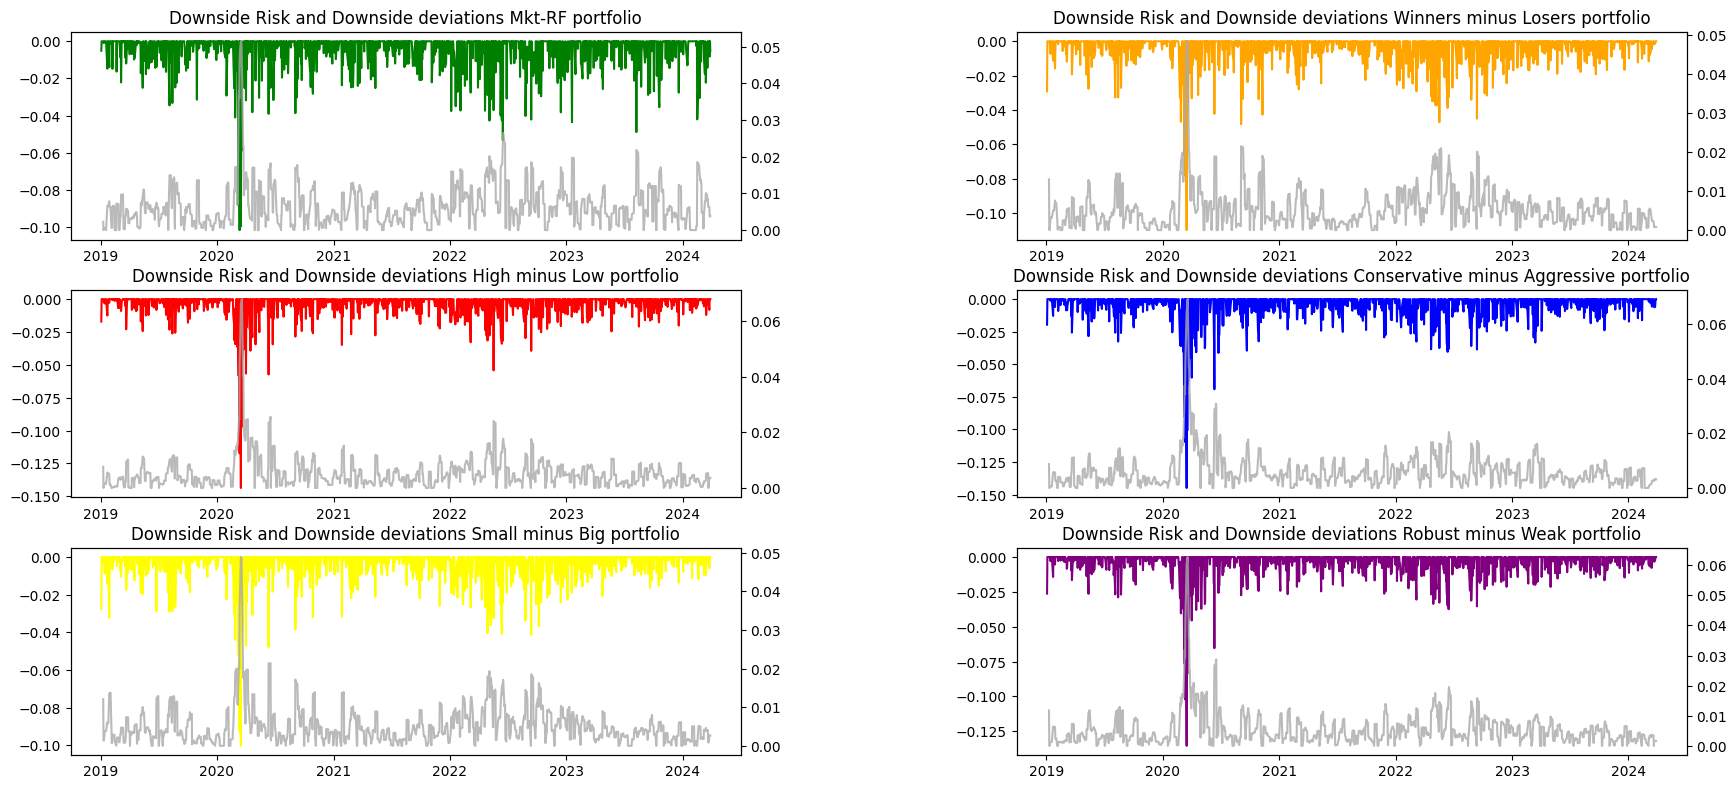

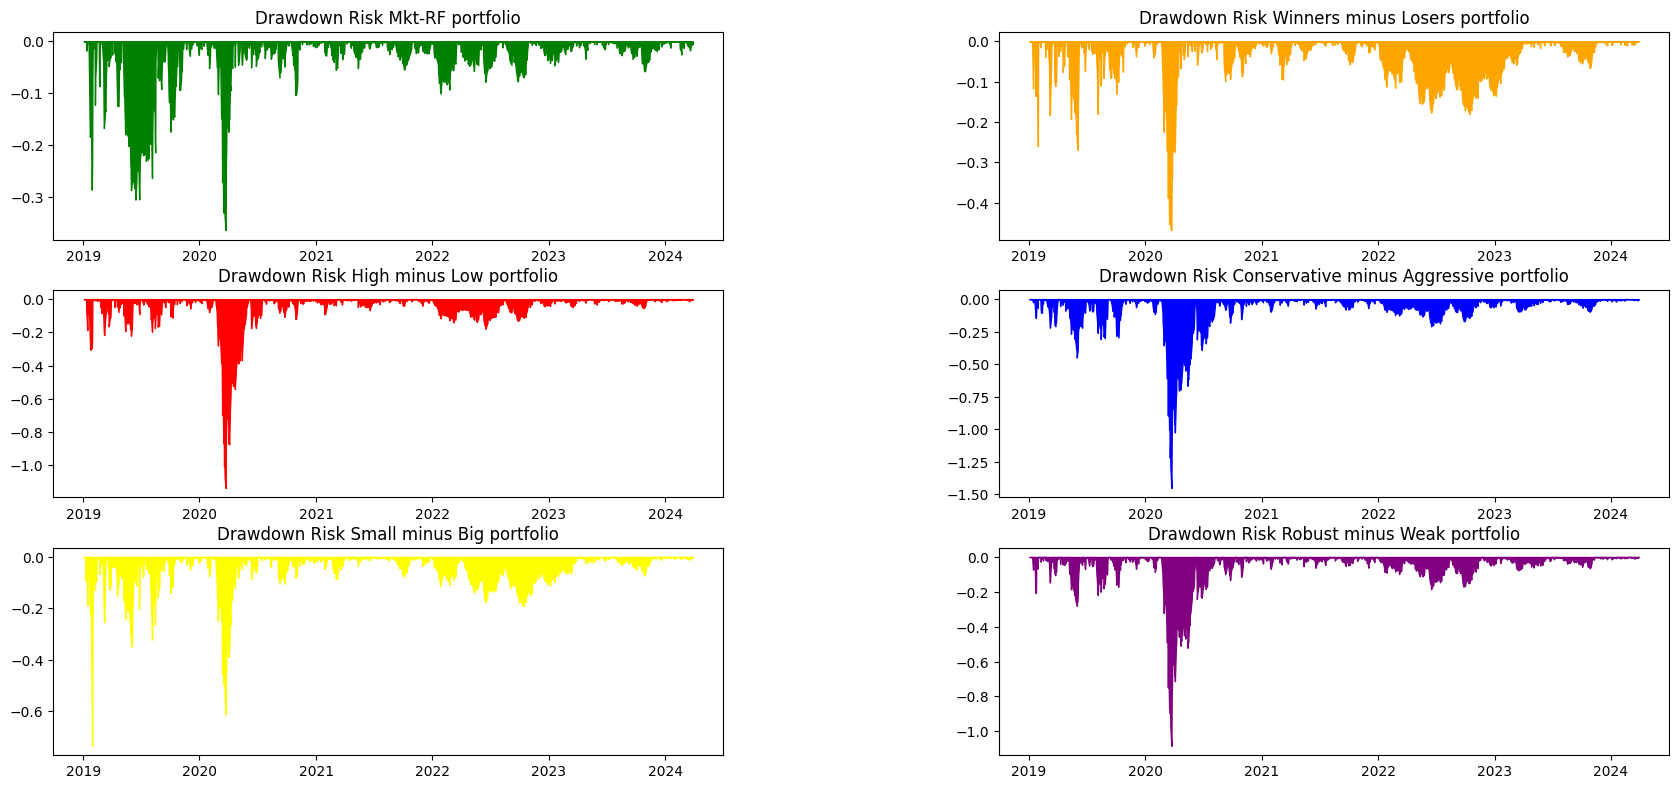

In [4]:
#Downside Risk
Downside = Port.map(lambda x: x if x < 0 else 0)

#Plot
plt.rcParams['figure.figsize'] = (30,20)
ax1 = plt.subplot2grid((36,10), (0,0), rowspan = 5, colspan = 3)
ax2 = plt.subplot2grid((36,10), (6,0), rowspan = 5, colspan = 3)
ax3 = plt.subplot2grid((36,10), (12,0), rowspan = 5, colspan = 3)
ax4 = plt.subplot2grid((36,10), (0,4), rowspan = 5, colspan = 3)
ax5 = plt.subplot2grid((36,10), (6,4), rowspan = 5, colspan = 3)
ax6 = plt.subplot2grid((36,10), (12,4), rowspan = 5, colspan = 3)

ax1.plot(Downside["Port_Mkt"],color="green",label="Downside")
ax1a = ax1.twinx()
ax1a.plot(Downside["Port_Mkt"].rolling(5).std(),color="darkgrey",label="Downside deviation",alpha=0.8)
ax1.set_title("Downside Risk and Downside deviations Mkt-RF portfolio")

ax2.plot(Downside["Port_HML"],color="red")
ax2a = ax2.twinx()
ax2a.plot(Downside["Port_HML"].rolling(5).std(),color="darkgrey",label="Downside deviation",alpha=0.8)
ax2.set_title("Downside Risk and Downside deviations High minus Low portfolio")

ax3.plot(Downside["Port_SMB"],color="yellow")
ax3.set_title("Downside Risk and Downside deviations Small minus Big portfolio")
ax3a = ax3.twinx()
ax3a.plot(Downside["Port_SMB"].rolling(5).std(),color="darkgrey",label="Downside deviation",alpha=0.8)

ax4.plot(Downside["Port_WML"],color="orange")
ax4.set_title("Downside Risk and Downside deviations Winners minus Losers portfolio")
ax4a = ax4.twinx()
ax4a.plot(Downside["Port_WML"].rolling(5).std(),color="darkgrey",label="Downside deviation",alpha=0.8)

ax5.plot(Downside["Port_CMA"],color="blue")
ax5.set_title("Downside Risk and Downside deviations Conservative minus Aggressive portfolio")
ax5a = ax5.twinx()
ax5a.plot(Downside["Port_CMA"].rolling(5).std(),color="darkgrey",label="Downside deviation",alpha=0.8)

ax6.plot(Downside["Port_RMW"],color="purple")
ax6.set_title("Downside Risk and Downside deviations Robust minus Weak portfolio")
ax6a = ax6.twinx()
ax6a.plot(Downside["Port_RMW"].rolling(5).std(),color="darkgrey",label="Downside deviation",alpha=0.8)

plt.show()

#Drawdon Risk
Drawdown = pd.DataFrame()

for Portfolio in Port.columns:
    cum = Port[Portfolio].cumsum()
    cum_max = cum.cummax()
    Drawdown[Portfolio] = (cum - cum_max)/ cum_max

plt.rcParams['figure.figsize'] = (30,20)
ax1 = plt.subplot2grid((36,10), (0,0), rowspan = 5, colspan = 3)
ax2 = plt.subplot2grid((36,10), (6,0), rowspan = 5, colspan = 3)
ax3 = plt.subplot2grid((36,10), (12,0), rowspan = 5, colspan = 3)
ax4 = plt.subplot2grid((36,10), (0,4), rowspan = 5, colspan = 3)
ax5 = plt.subplot2grid((36,10), (6,4), rowspan = 5, colspan = 3)
ax6 = plt.subplot2grid((36,10), (12,4), rowspan = 5, colspan = 3)

ax1.fill_between(Drawdown.index,Drawdown["Port_Mkt"],color="green")
ax1.set_title("Drawdown Risk Mkt-RF portfolio")
ax2.fill_between(Drawdown.index,Drawdown["Port_HML"],color="red")
ax2.set_title("Drawdown Risk High minus Low portfolio")
ax3.fill_between(Drawdown.index,Drawdown["Port_SMB"],color="yellow")
ax3.set_title("Drawdown Risk Small minus Big portfolio")
ax4.fill_between(Drawdown.index,Drawdown["Port_WML"],color="orange")
ax4.set_title("Drawdown Risk Winners minus Losers portfolio")
ax5.fill_between(Drawdown.index,Drawdown["Port_CMA"],color="blue")
ax5.set_title("Drawdown Risk Conservative minus Aggressive portfolio")
ax6.fill_between(Drawdown.index,Drawdown["Port_RMW"],color="purple")
ax6.set_title("Drawdown Risk Robust minus Weak portfolio")
plt.show()